---

This notebook contains code to re-create **Figure 10** from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, David L. Tabb, Miguel Carcamo & Joe Hanson

**Note:** The flagging and noise realisations implemented in this notebook are stochastic, so the figure will have the same properties as the one that appears in the paper but is unlikely to be identical.

---

In [1]:
import autograd.numpy as np
import pylab as pl
import os,sys
from tqdm import tqdm_notebook

In [2]:
from faraday_models import *
from faraday_stuff import *
from celerite_base import *

In [3]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

---
### Create data

In [4]:
def make_thin(i0,pfrac,alpha,phi,chi,l2):
    
    p0 = pfrac*i0
    alpha = 0.7
    nu0 = 1.4e9
    nu = 3e8/np.sqrt(l2)
    k = (nu/nu0)**(-1*alpha)
    mu_q = p0*k*np.cos(2.*(phi*l2 + chi))
    mu_u = p0*k*np.sin(2.*(phi*l2 + chi))
    
    return mu_q, mu_u

Observational parameters of MeerKAT MIGHTEE:

In [5]:
const_c = 3e8

nu_min = 8.8119e8
del_nu = 2.5103e6
nchan  = 320
nu_max = nu_min + nchan*del_nu

nu = np.linspace(nu_min, nu_max, nchan)
l2 = (const_c/nu)**2

l2_min = (const_c/nu_max)**2
l2_max = (const_c/nu_min)**2

# make regular sampling in lambda^2:
t1 = np.linspace(l2_min, l2_max, 512)

Calculate minimum rotation measure:

In [6]:
delta_l2 = l2_max-l2_min
rm_lim = 0.5*np.pi/(2.*delta_l2)
print("Minimum rotation measure: {:.2f} rad/m^2".format(rm_lim))

Minimum rotation measure: 9.33 rad/m^2


Observational noise for MeerKAT MIGHTEE field:

In [7]:
noise_int = 10e-6
noise_chan = noise_int*np.sqrt(nchan)

Build population of 10k sources:

In [8]:
msrc = 10000

i0 = np.random.uniform(1e-5, 3e-2, size=msrc)    # flux density @ 1.4GHz
alpha = 0.7*np.ones(msrc)                        # spectral index
phi = np.random.uniform(-100.,100, size=msrc)    # rotation measure
chi = np.random.uniform(-np.pi,np.pi,size=msrc)  # intrinsic polarization angle

log_pfrac = -1.*np.random.normal(0.051,0.004,size=msrc)*np.log(i0/1e-3) + np.random.normal(0.388,0.007,size=msrc)
pfrac = np.exp(log_pfrac)/100.                   # polarization fraction

parms = np.vstack((i0,pfrac,alpha,phi,chi))

---
### Fit data

In [9]:
nsrc = 500

In [10]:
tmp = np.arange(0,parms.shape[1])
np.random.shuffle(tmp)

In [11]:
_results=[]; _parms=[]
maxsrc = False
for i in tqdm_notebook(range(nsrc)):
    
    while True:
        src = tmp[i]
        
        if src>=msrc: 
            maxsrc = True
            break

        i0, pfrac, alpha, phi, chi = parms[:,src]

        stokesQ, stokesU = make_thin(i0,pfrac,alpha, phi, chi, l2)
        p0 = np.mean(np.sqrt(stokesQ**2+stokesU**2))
        snr = p0/noise_int
        
        #print(i0, pfrac, alpha, phi, chi, snr)
        
        if snr<8 or np.abs(phi)<rm_lim:  # only use sources with SNR>8 and |phi|>rm_lim
            tmp = np.roll(tmp,-1)
        else:
            break

    if maxsrc: break

    stokesQn = stokesQ+np.random.normal(loc =0.0, scale=noise_chan, size = len(stokesQ))
    stokesUn = stokesU+np.random.normal(loc =0.0, scale=noise_chan, size = len(stokesQ))

    # optimize hyper-parameters of GP and make a prediction:
    GP = MyCelerite(noise_chan)
    GP.celerite_optimize(l2, stokesQn, stokesUn)  # fit to original frequency sampling
    mu_q, std_q, mu_u, std_u = GP.celerite_predict(stokesQn, stokesUn, t1)  # predict on regular lambda^2 spacing
    rm_ml,rm_ex,rm_lo,rm_up = GP.celerite_rmpred()
        
    _results.append([phi, rm_ml, rm_ex, rm_lo, rm_up, snr])
    _parms.append(parms[:,src])
    
results = np.array(_results)
parms = np.array(_parms)

---
### Make plot

First find difference between predicted RM and true RM:

In [12]:
rmdiff = np.zeros(results.shape[0])
for i in range(results.shape[0]):
    diff = results[i,0]-results[i,2]
    if diff<0.:
        rmdiff[i] = diff/results[i,3]
    else:
        rmdiff[i] = diff/results[i,4]

Then make plot:

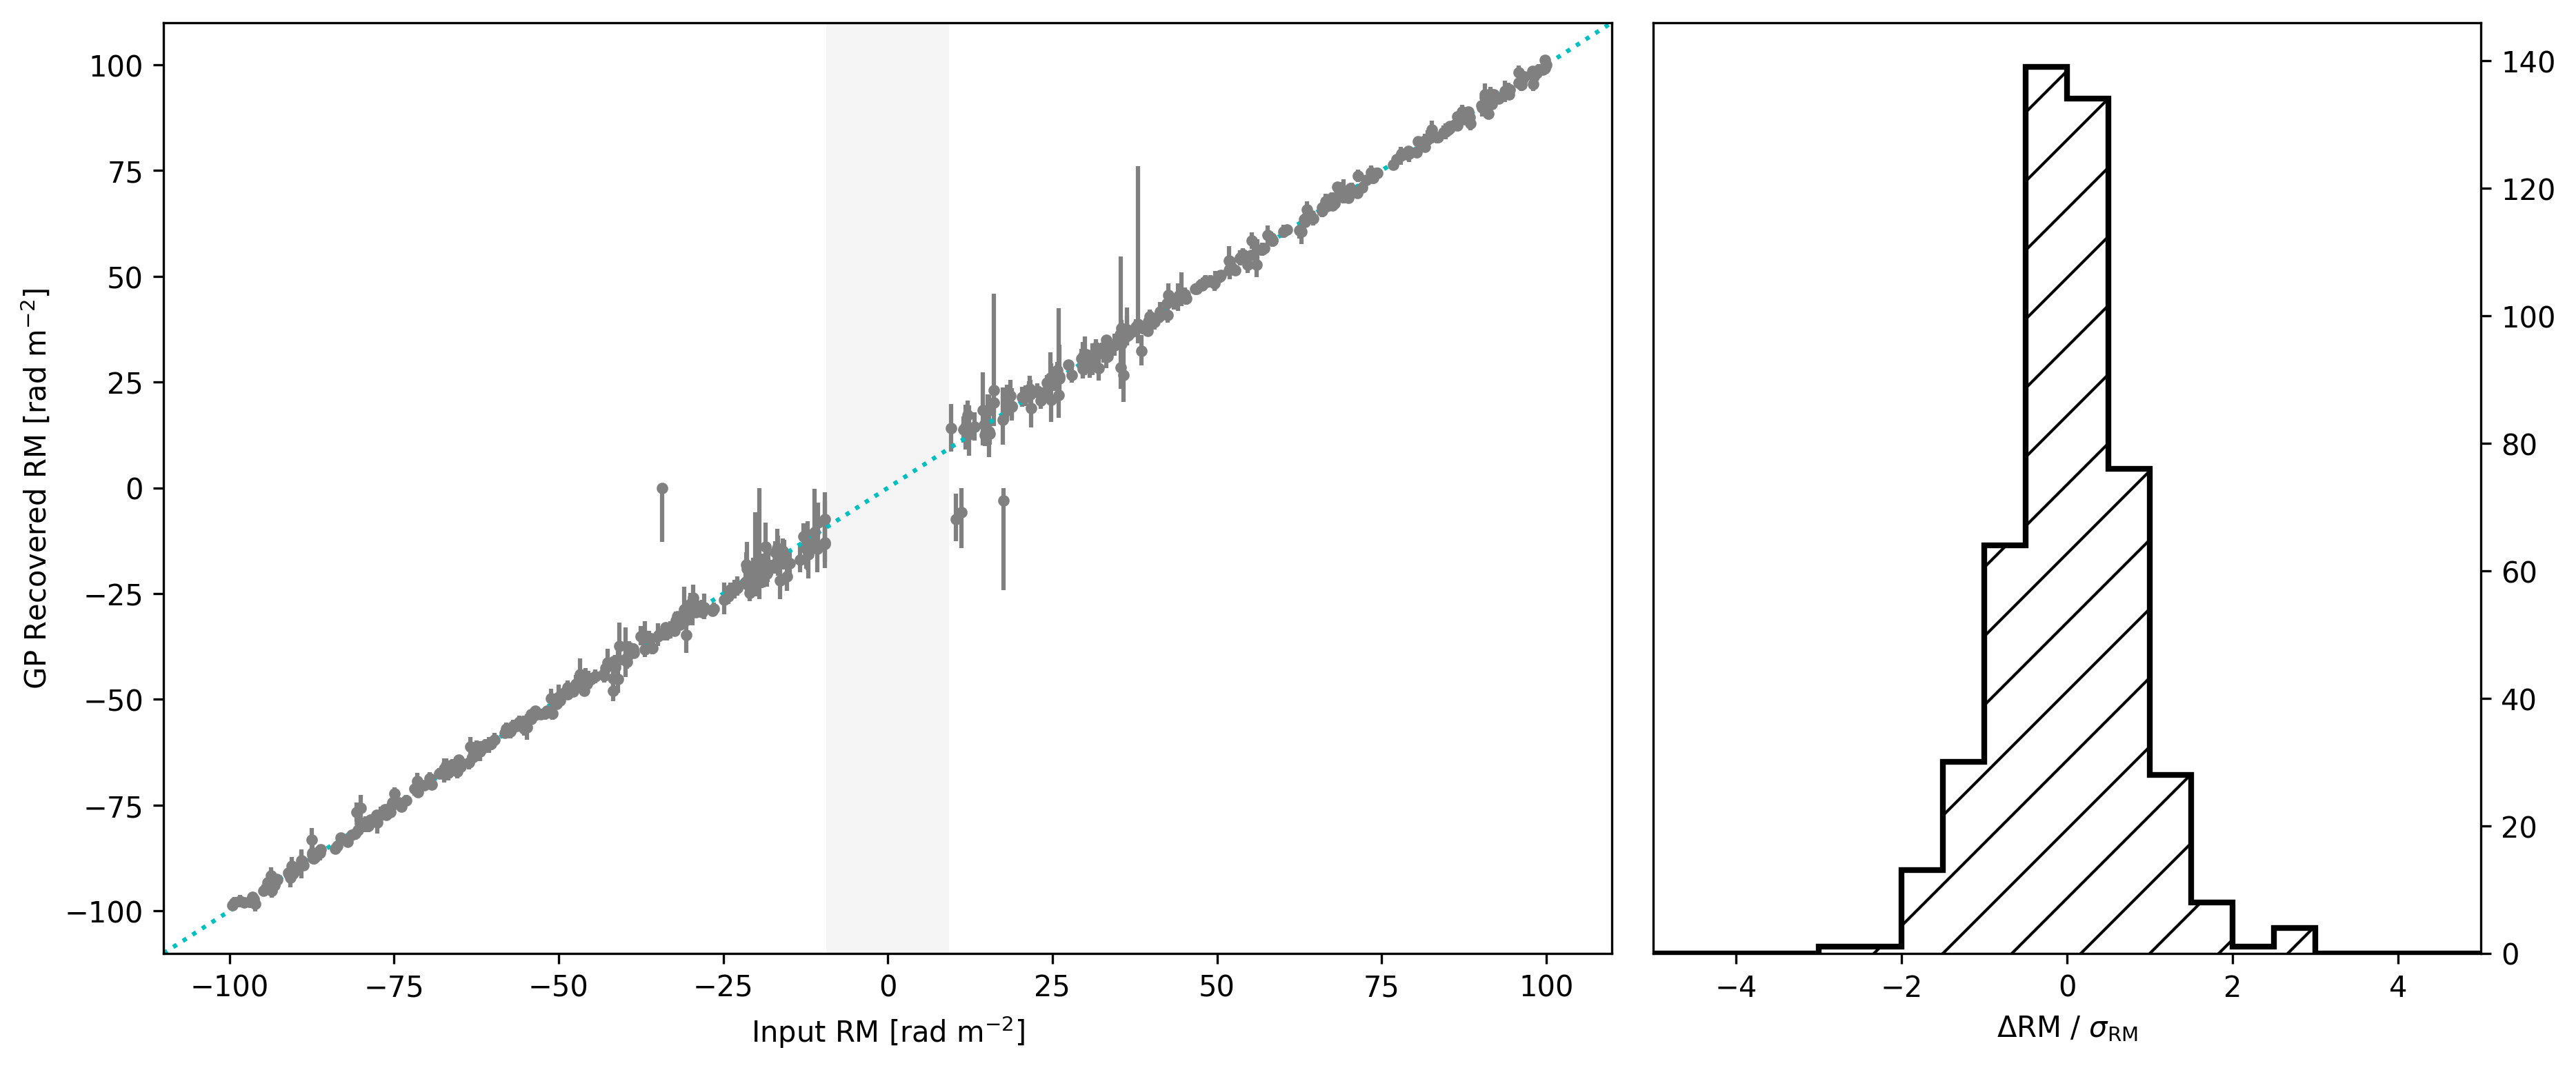

In [14]:
fig = pl.figure()

rm_err = [results[:,3],results[:,4]]

ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.9], ylim=(-110,110), xlim=(-110,110))
pl.fill_between([-rm_lim,rm_lim],[-110,-110],[110,110], facecolor='whitesmoke')
ax1.errorbar(results[:,0],results[:,2],yerr=rm_err,fmt='.', c='grey', capthick=0)
ax1.plot([-110,110],[-110,110],ls=':',c='c')
ax1.set_xlabel(r"Input RM [rad m$^{-2}$]")
ax1.set_ylabel(r"GP Recovered RM [rad m$^{-2}$]")

ax2 = fig.add_axes([0.82, 0.1, 0.4, 0.9])
n, bins, patches = ax2.hist(rmdiff, 20, density=False, range = (-5.,5.), histtype='step', linewidth=2, facecolor='none', hatch='/', edgecolor='k',fill=True)
ax2.set_xlabel(r"$\Delta$RM / $\sigma_{\rm RM}$")
#ax2.tick_params(labelleft=False)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlim(-5.,5.)
pl.show()

Calculate proportion within $\pm 3\sigma$:

In [23]:
print("Percentage of RMs within 3 sigma: {:.2f}".format(100.*len(rmdiff[np.where(np.abs(rmdiff)<3)])/500.))

Percentage of RMs within 3 sigma: 99.80


In [24]:
print("Number of objects with difference > 5 sigma: {}".format(results[np.where(np.abs(rmdiff)>5),:].shape[0]))

Number of objects with difference > 5 sigma: 1


In [25]:
print("Minimum SNR: {:.2f}; Maximum SNR: {:.2f}".format(np.min(results[:,-1]),np.max(results[:,-1])))

Minimum SNR: 8.02; Maximum SNR: 41.59


---
#### END